### **1. Importing libraries and Utils function**

In [1]:
# all necessary imports
import numpy as np 
import pandas as pd 
import re
from collections import Counter
import os
import json
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import transformers
import torch
from torch.utils.data import Dataset
from datasets import Dataset
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch as T
import numpy as np
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
import torch.nn as nn
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from argparse import Namespace
from transformers import BertModel
from transformers import AdamW
from PIL import Image
import requests
import cv2 
from transformers import CLIPProcessor, CLIPModel
import shutil 
import math
import torch.optim as optim
import pickle
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt 

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
!pip install datasets --upgrade

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
!pip install ipywidgets --upgrade
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


### **2. Dataset & Transformer**

#### **2.1 Dataset for Transformer**

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle

class CrossModalDataset(Dataset):
    def __init__(self, pickle_file, max_seq_length, num_choices, video_feature_size, device):

        with open(pickle_file, 'rb') as file:
            self.matchy = pickle.load(file)   # Loading Dataset from pickle file
        self.max_seq_length = max_seq_length
        self.num_choices = num_choices
        self.video_feature_size = video_feature_size
        self.device = device

    def __len__(self):
        return len(self.matchy)

    def __getitem__(self, idx):

        # If idx is a list (for batching), handle it accordingly
        if isinstance(idx, list):
            samples = [self.matchy[i] for i in idx]
            questions_embeddings = torch.stack([sample['questions_embeddings'] for sample in samples]).to(self.device)
            answers_embeddings = torch.stack([sample['answers_embeddings'] for sample in samples]).to(self.device)
            video_embeddings = torch.stack([sample['video_embeddings'] for sample in samples]).to(self.device)
            labels = torch.stack([torch.tensor(sample['label']).to(self.device) for sample in samples])
        else:
            sample = self.matchy[idx]
            questions_embeddings = sample['questions_embeddings'].to(self.device)
            answers_embeddings = sample['answers_embeddings'].to(self.device)
            video_embeddings = sample['video_embeddings'].to(self.device)  # Shape: [num_frames, video_feature_size]
            labels = sample['label'].to(self.device)  # Shape: [num_choices]

        #print("text_embeddings", text_embeddings.shape)
        #print("video_embeddings", video_embeddings.shape)
        #print("labels", labels.shape)
        # Padding or truncating video embeddings to match max_seq_length
        #num_frames = video_embeddings.size(0)
        #if num_frames < self.max_seq_length:
        #    padding = torch.zeros(self.max_seq_length - num_frames, self.video_feature_size).to(self.device)
            #print("padding", padding.shape)
        #    video_embeddings = torch.cat((video_embeddings, padding), dim=0)  # Concatenate padding correctly
        #elif num_frames > self.max_seq_length:
        #    video_embeddings = video_embeddings[:self.max_seq_length, :]  # Truncate to max_seq_length
            #print("> video_embeddings", video_embeddings.shape)
        

        # Return the sample embeddings and labels
        return {
            'question_embeddings': questions_embeddings,  # Shape: [num_choices, seq_length, d_model]
            'answers_embeddings' : answers_embeddings,
            'video_embeddings': video_embeddings,  # Shape: [max_seq_length, video_feature_size]
            'labels': labels  # Shape: [num_choices]
        }


In [6]:
def collate_fn(batch):
    # Find the maximum text embedding length in the batch
    max_seq_length = max(sample['question_embeddings'].size(1) for sample in batch)
    #print("max_seq_length", max_seq_length)

    # Pad text embeddings and video embeddings
    questions_embeddings = torch.stack([
        torch.cat([sample['question_embeddings'],
                   torch.zeros(sample['question_embeddings'].size(0), max_seq_length - sample['question_embeddings'].size(1), sample['question_embeddings'].size(2)).to(sample['question_embeddings'].device)], dim=1)
        if sample['question_embeddings'].size(1) < max_seq_length else sample['question_embeddings']
        for sample in batch
    ])

    # Find the maximum sequence length for answers in the batch
    max_answer_seq_length = max(sample['answers_embeddings'].size(1) for sample in batch)
    #print("max_answer_seq_length", max_answer_seq_length)

    # Pad or truncate answer embeddings
    answers_embeddings = torch.stack([
        torch.cat([sample['answers_embeddings'],
                   torch.zeros(sample['answers_embeddings'].size(0), max_answer_seq_length - sample['answers_embeddings'].size(1), sample['answers_embeddings'].size(2)).to(sample['answers_embeddings'].device)], dim=1)
        if sample['answers_embeddings'].size(1) < max_answer_seq_length else sample['answers_embeddings']
        for sample in batch
    ])


    # Find the maximum sequence length for videos in the batch
    max_video_seq_length = max(sample['video_embeddings'].size(0) for sample in batch)
    #print("max_video_seq_length", max_video_seq_length)

    # Pad or truncate video embeddings
    video_embeddings = torch.stack([
        torch.cat([sample['video_embeddings'],
                   torch.zeros(max_video_seq_length - sample['video_embeddings'].size(0), sample['video_embeddings'].size(1)).to(sample['video_embeddings'].device)], dim=0)
        if sample['video_embeddings'].size(0) < max_video_seq_length else sample['video_embeddings']
        for sample in batch
    ])
    
    
    labels = torch.tensor([sample['labels'] for sample in batch])

    return {
        'questions_embeddings': questions_embeddings,  # Shape: [num_choices, seq_length, d_model]
        'answers_embeddings' : answers_embeddings,
        'video_embeddings': video_embeddings,  # [batch_size, max_seq_length, video_feature_size]
        'labels': labels  # [batch_size]
    }


In [7]:
''' 
# Testing 
max_seq_length = 128  # Example: maximum sequence length for text
num_choices = 5  # Example: number of choices for multiple-choice
video_feature_size = 512  # Example: size of video feature vector (e.g., from a CNN)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pickle_file = "/kaggle/input/output-pickle-200-new-text/output_pickle_200_new_text_enc.pkl"
# Create dataset and dataloader
dataset = CrossModalDataset(pickle_file, max_seq_length, num_choices, video_feature_size, device)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn = collate_fn)  # You can adjust the batch size

# Iterate through the DataLoader
for batch in dataloader:
    #print(batch['text_embeddings'].shape)  # Check the shape of text embeddings
    print(batch["questions_embeddings"].shape)
    print(batch["answers_embeddings"].shape)
    print(batch['video_embeddings'].shape)  # Check the shape of video embeddings
    print(batch['labels'].shape)  # Check the shape of labels
    break
''' 

' \n# Testing \nmax_seq_length = 128  # Example: maximum sequence length for text\nnum_choices = 5  # Example: number of choices for multiple-choice\nvideo_feature_size = 512  # Example: size of video feature vector (e.g., from a CNN)\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\n\npickle_file = "/kaggle/input/output-pickle-200-new-text/output_pickle_200_new_text_enc.pkl"\n# Create dataset and dataloader\ndataset = CrossModalDataset(pickle_file, max_seq_length, num_choices, video_feature_size, device)\ndataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn = collate_fn)  # You can adjust the batch size\n\n# Iterate through the DataLoader\nfor batch in dataloader:\n    #print(batch[\'text_embeddings\'].shape)  # Check the shape of text embeddings\n    print(batch["questions_embeddings"].shape)\n    print(batch["answers_embeddings"].shape)\n    print(batch[\'video_embeddings\'].shape)  # Check the shape of video embeddings\n    print(batch[

#### **2.2 Cross Modal Transformer**

In [8]:
# Classic Transformer Architecture 

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn_scores = torch.clamp(attn_scores, min=-1e9, max=1e9)  # Clamp extreme values
        
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_probs = torch.nan_to_num(attn_probs, nan=0.0, posinf=1.0, neginf=0.0)  # Fix softmax instability
        
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        assert not torch.isnan(Q).any(),f"Contains NaN in Q input"
        assert not torch.isnan(K).any(),f"Contains NaN in K input"
        assert not torch.isnan(V).any(),f"Contains NaN in V input"
        
        
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        assert not torch.isnan(Q).any(),f"Contains NaN after splitting heads Q"
        assert not torch.isnan(K).any(),f"Contains NaN after splitting heads K"
        assert not torch.isnan(V).any(),f"Contains NaN after splitting heads V"
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        assert not torch.isnan(attn_output).any(),f"Contains NaN in attention_output"
        
        output = self.W_o(self.combine_heads(attn_output))
        assert not torch.isnan(output).any(),f"Contains NaN in output after combining heads"
        
        return output


class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x))) 
 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))  # Shape: [1, max_seq_length, d_model]
        
    def forward(self, x):
        # If x.dim() == 4, then we are adding a Positional Encoding to a Text Embedding 
        if x.dim() == 4:
            # Ensure the sequence length matches the positional encoding size
            seq_length = x.size(2)  # This is `seq_length` in [batch_size, num_choices, seq_length, d_model]
            assert seq_length <= self.pe.size(1), "Input sequence length exceeds maximum sequence length in positional encoding"
    
            # Apply positional encoding
            pe = self.pe[:, :seq_length, :]  # Slice the positional encoding to match the input length
            return x + pe

        # If x.dim() == 3, then we are adding a Positional Encoding to a Video Embedding
        if x.dim() == 3: 
            seq_length = x.size(1)
            assert seq_length <= self.pe.size(1), "Input sequence length exceeds maximum sequence length in positional encoding"

            # Apply positional encoding
            pe = self.pe[:, :seq_length]  # Slice the positional encoding to match the input length
            return x + pe

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


class CrossModalTransformer(nn.Module):
    def __init__(self, 
                 text_feature_size, 
                 video_feature_size, 
                 num_choices, 
                 d_model, 
                 num_heads, 
                 d_ff, 
                 max_seq_length,
                 num_decoder_layers, 
                 dropout=0.1):
        super(CrossModalTransformer, self).__init__()

        self.d_model = d_model
        self.questions_embeddings = nn.Linear(text_feature_size, d_model)
        self.answers_embeddings = nn.Linear(text_feature_size, d_model)
        self.video_embedding = nn.Linear(video_feature_size, d_model)

        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.cls_token = nn.Parameter(torch.randn(1, 1, 1, d_model))
        
        self.first_decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_decoder_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_decoder_layers)])

        self.classifier = nn.Linear(d_model, 1)
        self.apply(self.initialize_weights)

    
    def initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, questions_embeddings, answers_embeddings, video_embeddings, text_mask=None, video_mask=None):
        #print("question_embeddings forward init", questions_embeddings.shape)   # [batch_size, 1, max_question_len, bert_emb]
        #print("answers_embeddings forward init", answers_embeddings.shape)  # [batch_size, num_choices, max_answer_len, bert_emb]
        #print("video_embeddings forward init", video_embeddings.shape)      # [batch_size, max_frames_len, video_feature_size]
        assert not torch.isnan(questions_embeddings).any(),f"Contains NaN questions_embeddings forward init"
        assert not torch.isnan(answers_embeddings).any(),f"Contains NaN answers_embeddings forward init"
        assert not torch.isnan(video_embeddings).any(),f"Contains NaN video_embeddings forward init"


        batch_size, _, max_questions_len, bert_emb_question = questions_embeddings.size()
        batch_size, num_choices, max_seq_len, bert_emb_answer = answers_embeddings.size()
        _, video_seq_length, video_feature_size = video_embeddings.size()
    
        assert video_feature_size == self.d_model, "Video feature size must match d_model"
     
        questions_embeddings = self.questions_embeddings(questions_embeddings)      # [batch_size, 1, max_question_len, d_model]
        #print("questions_embeddings after embedding projection", questions_embeddings.shape) 
        answers_embeddings = self.answers_embeddings(answers_embeddings)      # [batch_size, 1, max_question_len, d_model]
        #print("answers_embeddings after embedding projection", answers_embeddings.shape)
        video_embeddings = self.video_embedding(video_embeddings)    # [batch_size, max_frames_len, video_feature_size]
        #print("video_embeddings after embedding projection", video_embeddings.shape)
        assert not torch.isnan(questions_embeddings).any(),f"Contains NaN question_embeddings after embedding projection"
        assert not torch.isnan(answers_embeddings).any(),f"Contains NaN answers_embeddings after embedding projection"
        assert not torch.isnan(video_embeddings).any(),f"Contains NaN text_embeddings after embedding projection"

        
        # Apply positional encoding to both text and video embeddings
        questions_embeddings =  self.positional_encoding(questions_embeddings)   # [batch_size, 1, max_question_len, d_model]
        #print("questions_embeddings after positional", questions_embeddings.shape)
        answers_embeddings = self.positional_encoding(answers_embeddings)    # [batch_size, 1, max_question_len, d_model]
        #print("answers_embeddings after positional", answers_embeddings.shape)
        video_embeddings = self.positional_encoding(video_embeddings)  # [batch_size, max_frames_len, video_feature_size]
        #print("video_embeddings after positional", video_embeddings.shape)
        assert not torch.isnan(questions_embeddings).any(),f"Contains NaN question_embeddings after embedding projection"
        assert not torch.isnan(answers_embeddings).any(),f"Contains NaN answers_embeddings after embedding projection"
        assert not torch.isnan(video_embeddings).any(),f"Contains NaN text_embeddings after positional"


        questions_embeddings = questions_embeddings.view(batch_size, max_questions_len, self.d_model)  # Flatten to [batch_size, seq_length, d_model]
        #print("questions_embeddings after view for decoder1", questions_embeddings.shape)
        
        decoder1_output = questions_embeddings
        for layer in self.first_decoder_layers:
            decoder1_output = layer(
                x=decoder1_output, # keys_values
                enc_output=video_embeddings,   #queries 
                src_mask=video_mask, 
                tgt_mask=text_mask
            )
            #print("decoder1_output layer", decoder1_output.shape)    # [batch_size, max_questions_len, d_model]

        #print("decoder_1_output final", decoder1_output.shape)    # [batch_size, max_questions_len, d_model]

        # Add cls_token to answers_embeddings
        cls_token = self.cls_token.expand(batch_size, num_choices, 1, self.d_model)  # Shape: [batch_size, num_choices, 1, d_model]
        concatenated_answers_embeddings = torch.cat([cls_token, answers_embeddings], dim=2)
        #print("answers_embeddings + cls_token", concatenated_answers_embeddings.shape)

        concatenated_answers_embeddings = concatenated_answers_embeddings.view(batch_size * num_choices, max_seq_len+1, self.d_model)
    
        # Second Decoder
        decoder2_output = concatenated_answers_embeddings
        for layer in self.decoder_layers:
            decoder2_output = layer(
                x=decoder2_output,
                enc_output=decoder1_output.repeat_interleave(num_choices, dim=0),
                src_mask=text_mask,
                tgt_mask=text_mask
            )
            #print("decoder2_output layer", decoder2_output.shape)
        #print("decoder_2_output final", decoder2_output.shape)  # [batch_size, num_choices, seq_length + 1, d_model]

        
        # Extract the first token from decoder2_output
        cls_tokens = decoder2_output[:, 0, :]  # [batch_size*num_choices, d_model]
        #print("cls_tokens", cls_tokens.shape)
    
        # Pass through a linear layer to project to 1 dimension
        logits = self.classifier(cls_tokens)  # [batch_size * num_choices, 1]
        #print("logits after linear layer", logits.shape)
    
        # Reshape back to [batch_size, num_choices]
        logits = logits.view(batch_size, num_choices)
        #print("final logits", logits.shape)
    
        return logits

      

In [9]:
# Parameters
max_seq_length = 128  # Example: maximum sequence length for text
num_choices = 5  # Example: number of choices for multiple-choice
video_feature_size = 512  # Example: size of video feature vector (e.g., from a CNN)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_pkl = "/kaggle/input/train-test-nlp/train_test_nlp/train_df.pkl"
test_pkl = "/kaggle/input/train-test-nlp/train_test_nlp/test_df.pkl"
#val_pkl =  "/kaggle/input/train-test-val-nlp/train_test_val_nlp/val_df.pkl"

# Create dataset and dataloader
train_dataset = CrossModalDataset(train_pkl, max_seq_length, num_choices, video_feature_size, device)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn = collate_fn) 
test_dataset = CrossModalDataset(test_pkl, max_seq_length, num_choices, video_feature_size, device)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn = collate_fn)  
#val_dataset = CrossModalDataset(val_pkl, max_seq_length, num_choices, video_feature_size, device)
#val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn = collate_fn) 



In [10]:
# Model Parameters
text_feature_size = 768  # Example size of the text embedding (e.g., from BERT)
# text_feature_size = 512 # Example size of the text embedding (e.g., from T5)
video_feature_size = 512  # Example size of the video embedding (e.g., from a CNN)
num_choices = 5  # Number of choices for multiple-choice
d_model = 512  # Transformer model size
num_heads = 8  # Number of attention heads
d_ff = 2048  # Feed-forward layer size
max_seq_length = 128  # Max sequence length for text
num_decoder_layers = 6  # Number of decoder layers

# Instantiate the model
model = CrossModalTransformer(
    text_feature_size, 
    video_feature_size, 
    num_choices, 
    d_model, 
    num_heads, 
    d_ff, 
    max_seq_length, 
    num_decoder_layers
).to(device)


# Training Parameters
epochs = 50
batch_size = 16  # Batch size for training
# learning_rate = 5e-5  # Learning rate for the optimizer
scaler = torch.amp.GradScaler()


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming the labels are categorical
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 0.01)  # You can adjust the learning rate


In [11]:
def train(model, data_loader, optimizer, criterion, scaler, device, epochs):
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for batch in data_loader:
            # Move batch data to the device
            questions_embeddings = batch["questions_embeddings"].to(device)
            answers_embeddings = batch["answers_embeddings"].to(device)
            video_embeddings = batch["video_embeddings"].to(device).squeeze(2)  # Adjust if necessary
            labels = batch["labels"].to(device)  # Shape: [batch_size]

            optimizer.zero_grad()  # Zero the gradients before backpropagation

            with torch.amp.autocast(device_type="cuda" if device.type == "cuda" else "cpu"):
                # Forward pass: Compute logits
                logits = model(questions_embeddings, answers_embeddings, video_embeddings)  # [batch_size, num_choices]

                # Compute loss
                loss = criterion(logits, labels)  # CrossEntropyLoss expects [batch_size, num_choices] and [batch_size]
            
            # Backward pass: Compute gradients
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        
            # Update the total loss and accuracy
            total_loss += loss.item()
            _, predicted = torch.max(logits, dim=1)  # Get predicted choice indices
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        # Compute average loss and accuracy for the epoch
        avg_loss = total_loss / len(data_loader)
        accuracy = (correct_predictions / total_samples) * 100

        # Store the metrics
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        # Print metrics for the epoch
        print(f"Epoch {epoch + 1}/{epochs}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")
    
    return epoch_losses, epoch_accuracies


In [12]:
# Call the train function
epoch_losses, epoch_accuracies = train(
    model=model,
    data_loader=train_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    scaler=scaler,
    device=device,
    epochs=epochs
)

Epoch 1/50: Loss = 1.6781, Accuracy = 19.00%
Epoch 2/50: Loss = 1.6545, Accuracy = 19.75%
Epoch 3/50: Loss = 1.6292, Accuracy = 24.50%
Epoch 4/50: Loss = 1.6217, Accuracy = 23.58%
Epoch 5/50: Loss = 1.6075, Accuracy = 24.75%
Epoch 6/50: Loss = 1.5864, Accuracy = 26.33%
Epoch 7/50: Loss = 1.5807, Accuracy = 28.08%
Epoch 8/50: Loss = 1.5459, Accuracy = 30.08%
Epoch 9/50: Loss = 1.5519, Accuracy = 30.67%
Epoch 10/50: Loss = 1.5307, Accuracy = 32.00%
Epoch 11/50: Loss = 1.5301, Accuracy = 32.33%
Epoch 12/50: Loss = 1.4939, Accuracy = 32.50%
Epoch 13/50: Loss = 1.4809, Accuracy = 35.75%
Epoch 14/50: Loss = 1.4162, Accuracy = 38.67%
Epoch 15/50: Loss = 1.3898, Accuracy = 40.42%
Epoch 16/50: Loss = 1.3627, Accuracy = 42.83%
Epoch 17/50: Loss = 1.3336, Accuracy = 44.00%
Epoch 18/50: Loss = 1.3109, Accuracy = 45.83%
Epoch 19/50: Loss = 1.2131, Accuracy = 51.17%
Epoch 20/50: Loss = 1.1690, Accuracy = 54.17%
Epoch 21/50: Loss = 1.0982, Accuracy = 54.50%
Epoch 22/50: Loss = 0.9851, Accuracy = 61.6

In [13]:
torch.save(model.state_dict(), "/kaggle/working/model.pth")

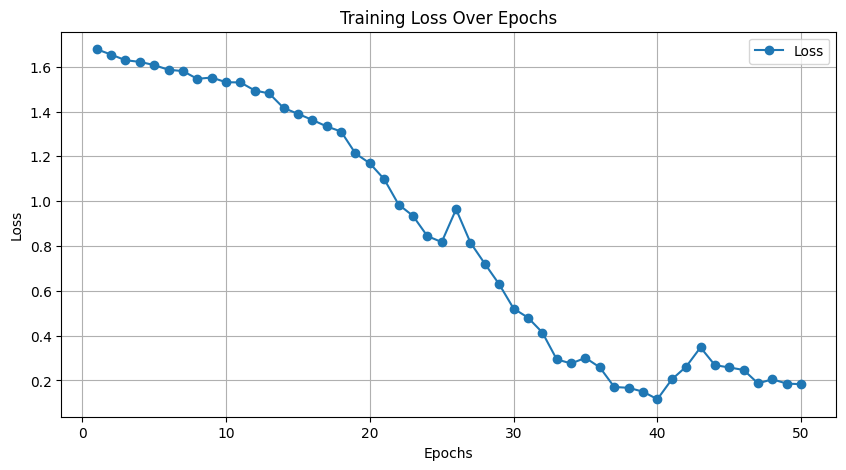

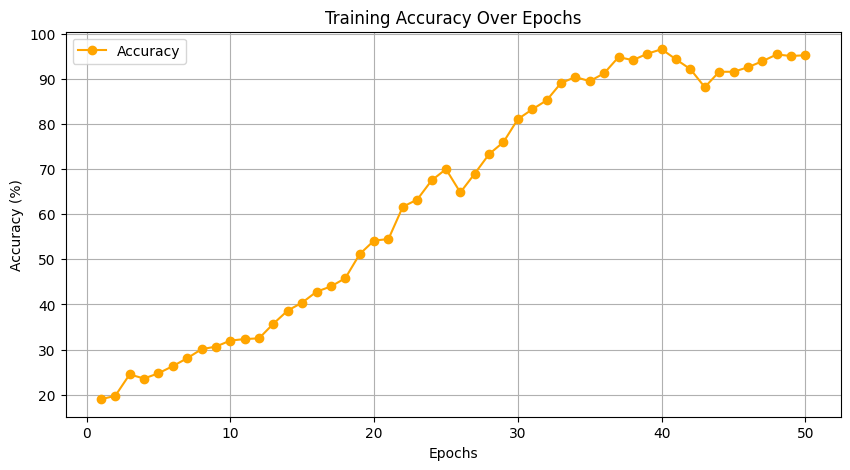

In [14]:
# Plotting the Results
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_losses, marker='o', label='Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_accuracies, marker='o', color='orange', label='Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()


In [15]:

for name, param in model.named_parameters():
    if param.grad is None:
        print(f"No grad for {name}")
    else:
        print(f"{name}: {param.grad.norm()}")

cls_token: 3.7684106501956194e-08
questions_embeddings.weight: 8.858020009938627e-06
questions_embeddings.bias: 3.6680248172160645e-07
answers_embeddings.weight: 3.497365833027288e-05
answers_embeddings.bias: 8.315932404912019e-07
video_embedding.weight: 1.448405055270996e-05
video_embedding.bias: 1.5485536550841061e-06
first_decoder_layers.0.self_attn.W_q.weight: 1.0763947102532256e-06
first_decoder_layers.0.self_attn.W_q.bias: 5.440726980054933e-08
first_decoder_layers.0.self_attn.W_k.weight: 1.1108771786894067e-06
first_decoder_layers.0.self_attn.W_k.bias: 5.5223347596167205e-12
first_decoder_layers.0.self_attn.W_v.weight: 4.621013431460597e-06
first_decoder_layers.0.self_attn.W_v.bias: 2.3365431900401745e-07
first_decoder_layers.0.self_attn.W_o.weight: 3.0205558232410112e-06
first_decoder_layers.0.self_attn.W_o.bias: 2.0018480029193597e-07
first_decoder_layers.0.cross_attn.W_q.weight: 3.964505026488041e-07
first_decoder_layers.0.cross_attn.W_q.bias: 2.2639651930944638e-08
first_dec

In [16]:
def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in data_loader:
            questions_embeddings = batch["questions_embeddings"].to(device)
            answers_embeddings = batch["answers_embeddings"].to(device)
            video_embeddings = batch["video_embeddings"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(questions_embeddings, answers_embeddings, video_embeddings)
            
            loss = criterion(logits, labels)
            total_loss += loss.item()
            _, predicted = torch.max(logits, dim=1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = (correct_predictions / total_samples) * 100
    return avg_loss, accuracy


In [18]:
# Evaluate the model
avg_loss_test, accuracy_test = evaluate(model, test_dataloader, criterion, device)

print(f"Average Loss: {avg_loss_test:.4f}")
print(f"Accuracy: {accuracy_test:.2f}%")


Average Loss: 4.3952
Accuracy: 39.62%
